## Emotion Recognition

Create a CNN models for emotion recognition from facial image.

**Using only Conv2D, Pooling Layers, Dense Layers, BatchNorm, LayerNorm, Activation Layers, Dropout**

**Fixed random seed**

Metric: 0.5 * Accuracy (**on Test**) + 0.5 * [macro F1-score] (**on Test**)

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

**Grading**

```
0.7+: 10
0.6+: 9
0.5+: 8
0.4+: 7
```

**Bonus**: +1~2 for Exploration Data Analysis (EDA)
```

## Initial Setting

### Libaries loading

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import torch

### Hyperparameter initializing

In [ ]:
RANDOM_STATE = 42
LEARNING_RATE = 0.0001
EPOCHS = 100
BATCH_SIZE = 32
NUM_CLASSES = 7

In [51]:
# manual seed
torch.manual_seed(RANDOM_STATE)

Check if there're any `GPU` appear

In [52]:
!nvidia-smi

Thu Jan 23 19:34:54 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2050        Off |   00000000:01:00.0 Off |                  N/A |
| N/A   42C    P8              1W /   50W |    1977MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [53]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


## Data Exploring

In [ ]:
train_path = r'/kaggle/input/fer2013/train'
test_path = r'/kaggle/input/fer2013/test'

In [54]:
data_path = "./fer13_v2.npy"

data = np.load(data_path, allow_pickle=True).item()

X_train, y_train = data['train']
X_val, y_val = data['val']
X_test, y_test = data['test']

In [55]:
# convert to tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

In [56]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

(torch.Size([28709, 48, 48]),
 torch.Size([28709]),
 torch.Size([3589, 48, 48]),
 torch.Size([3589]),
 torch.Size([3589, 48, 48]),
 torch.Size([3589]))

In [57]:
# convert to type torch float32
X_train = X_train.type(torch.float32)
X_val = X_val.type(torch.float32)
X_test = X_test.type(torch.float32)

y_train = y_train.type(torch.long)
y_val = y_val.type(torch.long)
y_test = y_test.type(torch.long)

In [58]:
# convert to pytorch format (N, C, H, W)
X_train = X_train.unsqueeze(1)
X_val = X_val.unsqueeze(1)
X_test = X_test.unsqueeze(1)

X_train.shape, X_val.shape, X_test.shape

(torch.Size([28709, 1, 48, 48]),
 torch.Size([3589, 1, 48, 48]),
 torch.Size([3589, 1, 48, 48]))

### Detemine emotion for each label
Do some **EDA** to show what the data have. What is the emotions exactly in each label?

In [59]:
# show unique value of y_train
y_train.unique()

tensor([0, 1, 2, 3, 4, 5, 6])

Take a look at 5 images of each labels, then I will determine what emotion for them exactly. 

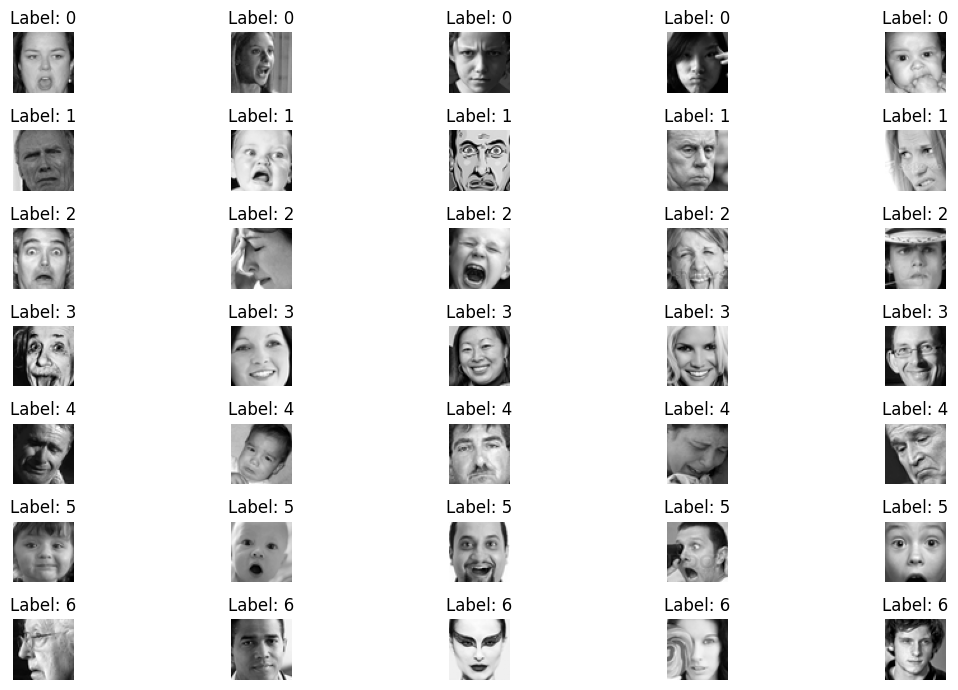

In [60]:
fig, axes = plt.subplots(ncols = 5, nrows = 7, figsize = (12, 7))

for i in range(7):
  tmp = X_train[y_train == i][45:50].squeeze()
  for j in range(5):
    axes[i, j].imshow(tmp[j], cmap = 'gray')
    axes[i, j].axis('off')
    axes[i, j].set_title(f"Label: {i}")

plt.tight_layout()
plt.show()

After *fine-tuning the indexes* in the figure above, I can decide what emotion each label belong to

**Label and their emotion**
|y |emotion|
|-----|-----|
|0| angry|
|1| diggust|
|2| scare|
|3| happy|
|4| sad|
|5| supprise|
|6| neutral|


### Class Imbalance
After that,  let take a look at the amount of each label in the train dataset a.k.a the ballance of the labels.

In [61]:
emotions = np.array(['angry', 'disgust', 'scare', 'happy', 'sad', 'surprise', 'neutral'])

In [62]:
# Show the count of class
emotion_count = pd.Series(y_train).value_counts().sort_index()
emotion_count

0    3995
1     436
2    4097
3    7215
4    4830
5    3171
6    4965
Name: count, dtype: int64

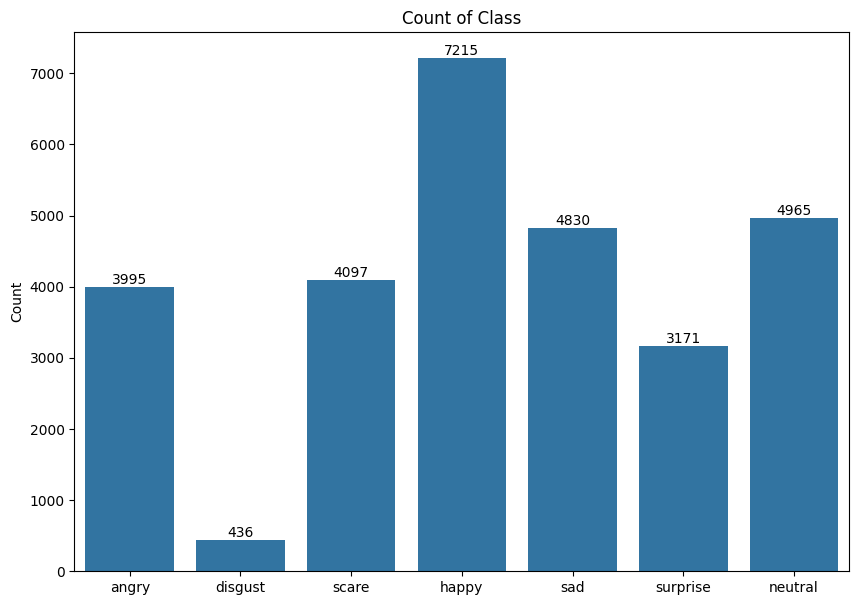

In [63]:
plt.figure(figsize = (10, 7))
ax = sns.barplot(y = emotion_count,
            x = emotions)

for i, v in enumerate(emotion_count.values):
    ax.text(i, v + 1, str(v), ha='center', va='bottom', fontsize=10)

plt.xlabel("")
plt.ylabel("Count")
plt.title("Count of Class")
plt.show()

There are **7215** images labeled as the class `happy` and only **436** images labeled as the class `disgust`—a ratio of approximately **16:1**. Such a significant class imbalance means that the model will naturally learn to focus more on the majority class (`happy`) during training because it minimizes the overall loss more effectively by simply predicting the dominant class.

Strategies to handle class imbalance
1. Change metrics
2. Undersampling
3. Upsampling
4. Customize class weight (using `sklearn.utils.class_weight.compute_class_weight` )

By customizing class weights, the model is penalized more for incorrect predictions on the minority class, which encourages it to focus more on correctly classifying these underrepresented samples.

In [64]:
from sklearn.utils.class_weight import compute_class_weight

In [65]:
class_weights = compute_class_weight(class_weight = 'balanced',
                                     classes = np.unique(y_train),
                                     y = y_train.numpy())

class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

In [66]:
class_weights

tensor([1.0266, 9.4066, 1.0010, 0.5684, 0.8491, 1.2934, 0.8260],
       device='cuda:0')

## Modeling


### Data Augmentation
The best way to improve the model is by collecting more data; however, this approach requires significant effort and resources. An alternative, though less effective, is **Data Augmentation**. Data Augmentation involves applying small transformations to the original images, such as flipping, rotating, applying affine transformations, cropping, and more.

Apply these changes in the `X_train` by `torchvision.transforms`. Let's take a look at what happen with the first image after using this technique.

In [67]:
# data augmentation
from torchvision.transforms import RandomHorizontalFlip, RandomRotation, RandomAffine, RandomPerspective, RandomResizedCrop, Compose

transforms = Compose([
    RandomHorizontalFlip(p = 0.5),
    RandomRotation(degrees = 15),
    RandomAffine(degrees = 15),
    RandomPerspective(),
    RandomResizedCrop(size = (48, 48))
])

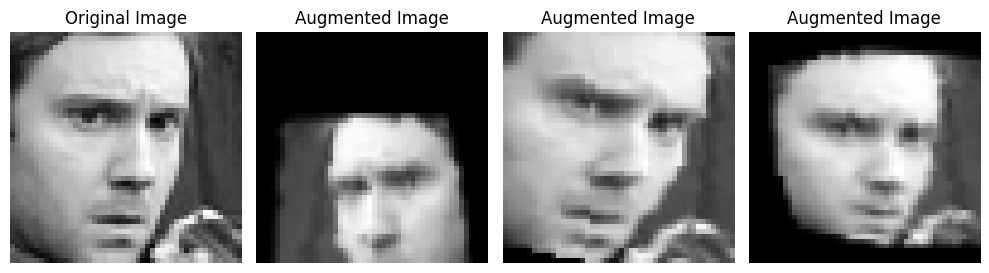

In [69]:
# show the image before and after augmentation
fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize = (10, 5))

axes[0].imshow(X_train[0].squeeze(), cmap = 'gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

for i in range(1, 4):
    augmented_image = transforms(X_train[0].unsqueeze(0))
    axes[i].imshow(augmented_image.squeeze(), cmap = 'gray')
    axes[i].set_title('Augmented Image')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [22]:
# using GPU
X_train = X_train.to(device)
y_train = y_train.to(device)

X_val = X_val.to(device)
y_val = y_val.to(device)

X_test = X_test.to(device)
y_test = y_test.to(device)

Then, apply this to the origin `X_train` and **concat** them together

In [23]:
# apply data augmentation
X_train_augmented = torch.stack([transforms(i) for i in X_train])

In [24]:
# merge the original and augmented data
X_train = torch.cat([X_train, X_train_augmented], dim = 0)
y_train = torch.cat([y_train, y_train], dim = 0)

In [25]:
X_train.shape

torch.Size([57418, 1, 48, 48])

Rescaling the data

In [27]:
# rescale the data
X_train = X_train / 255.
X_val = X_val / 255.
X_test = X_test / 255.

### Model Defining

In [72]:
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import Module, Conv2d, Linear, MaxPool2d, ReLU, Dropout, BatchNorm2d , Flatten, Softmax
from torch.optim import Adam
from torchsummary import summary

In [28]:
# create dataloader
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE,)
val_dataloader = DataLoader(val_dataset, batch_size = BATCH_SIZE,)
test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE,)

In [29]:
class CNN(Module):
    def __init__(self, channels, num_classes):
        super().__init__()

        # Convolutional layers
        self.conv1 = Conv2d(in_channels=channels, out_channels=32, kernel_size=(5, 5), padding=2)
        self.conv2 = Conv2d(in_channels=32, out_channels=64, kernel_size=(5, 5), padding=2)
        self.conv3 = Conv2d(in_channels=64, out_channels=128, kernel_size=(5, 5), padding=2)
        self.conv4 = Conv2d(in_channels=128, out_channels=512, kernel_size=(5, 5), padding=2)
        self.conv5 = Conv2d(in_channels=512, out_channels=1024, kernel_size=(3, 3), padding=1)

        # Batch normalization
        self.batchnorm1 = BatchNorm2d(num_features=32)
        self.batchnorm2 = BatchNorm2d(num_features=64)
        self.batchnorm3 = BatchNorm2d(num_features=128)
        self.batchnorm4 = BatchNorm2d(num_features=512)
        self.batchnorm5 = BatchNorm2d(num_features=1024)

        # Other layers
        self.maxpool = MaxPool2d(kernel_size=(2, 2))
        self.relu = ReLU()
        self.dropout = Dropout(p=0.2)

        # Fully connected layers
        self.flatten = Flatten()
        self.fc1 = Linear(in_features=1024, out_features=512)
        self.fc2 = Linear(in_features=512, out_features=128)
        self.fc3 = Linear(in_features=128, out_features=num_classes)
        self.softmax = Softmax(dim=1)

    

    def forward(self, X):
        # block 1
        X = self.conv1(X)
        X = self.batchnorm1(X)
        X = self.relu(X)
        X = self.maxpool(X)

        # block 2
        X = self.conv2(X)
        X = self.batchnorm2(X)
        X = self.relu(X)
        X = self.maxpool(X)

        # block 3
        X = self.conv3(X)
        X = self.batchnorm3(X)
        X = self.relu(X)
        X = self.maxpool(X)

        # block 4
        X = self.conv4(X)
        X = self.batchnorm4(X)
        X = self.relu(X)
        X = self.maxpool(X)
        X = self.dropout(X)

        # block 5
        X = self.conv5(X)
        X = self.batchnorm5(X)
        X = self.relu(X)
        X = self.maxpool(X)
        X = self.dropout(X)

        
        # fully connected layer
        X = self.flatten(X)
        X = self.fc1(X)
        X = self.relu(X)
        X = self.dropout(X)

        X = self.fc2(X)
        X = self.relu(X)
        X = self.dropout(X)

        X = self.fc3(X)
        return X


In [30]:
model = CNN(channels = 1, num_classes = NUM_CLASSES).to(device)

In [31]:
optimizer = Adam(params = model.parameters(), lr = LEARNING_RATE)

In [32]:
# loss fn
loss_fn = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32).to(device))

/tmp/ipykernel_63415/2094615562.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_fn = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32).to(device))


In [73]:
summary(model, (1, 48, 48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             832
       BatchNorm2d-2           [-1, 32, 48, 48]              64
              ReLU-3           [-1, 32, 48, 48]               0
         MaxPool2d-4           [-1, 32, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]          51,264
       BatchNorm2d-6           [-1, 64, 24, 24]             128
              ReLU-7           [-1, 64, 24, 24]               0
         MaxPool2d-8           [-1, 64, 12, 12]               0
            Conv2d-9          [-1, 128, 12, 12]         204,928
      BatchNorm2d-10          [-1, 128, 12, 12]             256
             ReLU-11          [-1, 128, 12, 12]               0
        MaxPool2d-12            [-1, 128, 6, 6]               0
           Conv2d-13            [-1, 512, 6, 6]       1,638,912
      BatchNorm2d-14            [-1, 51

### Model Training and Testing Loops Defining

In [33]:
# traning loop
def train_epoch(model, dataloader, loss_fn, optimizer):
  # turn on train phase
  model.train()
  running_loss = 0.0
  correct = 0
  total = 0

  for inputs, labels in dataloader:
    inputs, labels = inputs.to(device), labels.to(device)

    # forward pass
    outputs = model(inputs)

    # calculate loss
    loss = loss_fn(outputs, labels)

    # zero gradient
    optimizer.zero_grad()

    # backpropagation
    loss.backward()

    # update
    optimizer.step()

    # save loss and accuracy
    running_loss += loss.item()
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  epoch_loss = running_loss / len(dataloader)
  epoch_acc = 100 * correct / total

  return epoch_loss, epoch_acc

In [34]:
# testing loop
def test_epoch(model, dataloader, loss_fn):
  # turn on test phase
  model.eval()
  correct = 0
  total = 0

  with torch.inference_mode():
    for inputs, labels in dataloader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  epoch_acc = 100 * correct / total

  return epoch_acc

### Train the model through EPOCHS

In [35]:
# best acc
best_acc = 0.0
train_loss_list = []
train_acc_list = []
val_acc_list = []

for epoch in range(EPOCHS):
  train_loss, train_acc = train_epoch(model, train_dataloader, loss_fn, optimizer)
  val_acc = test_epoch(model, val_dataloader, loss_fn)

  train_loss_list.append(train_loss)
  train_acc_list.append(train_acc)
  val_acc_list.append(val_acc)

  # save best model
  if val_acc > best_acc:
    best_acc = val_acc
    torch.save(model.state_dict(), 'best_model.pth')

  print(f"Epoch [{epoch+1}/{EPOCHS}]")
  print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
  print(f"Val Acc: {val_acc:.2f}%")
  print('-'*50)

Epoch [1/100]
Train Loss: 1.8121 | Train Acc: 28.52%
Val Acc: 39.57%
--------------------------------------------------
Epoch [2/100]
Train Loss: 1.6199 | Train Acc: 37.15%
Val Acc: 45.05%
--------------------------------------------------
Epoch [3/100]
Train Loss: 1.4970 | Train Acc: 41.61%
Val Acc: 46.28%
--------------------------------------------------
Epoch [4/100]
Train Loss: 1.3913 | Train Acc: 45.23%
Val Acc: 47.20%
--------------------------------------------------
Epoch [5/100]
Train Loss: 1.2898 | Train Acc: 48.24%
Val Acc: 46.92%
--------------------------------------------------
Epoch [6/100]
Train Loss: 1.2139 | Train Acc: 51.06%
Val Acc: 49.12%
--------------------------------------------------
Epoch [7/100]
Train Loss: 1.1369 | Train Acc: 53.49%
Val Acc: 50.24%
--------------------------------------------------
Epoch [8/100]
Train Loss: 1.0721 | Train Acc: 55.97%
Val Acc: 51.32%
--------------------------------------------------
Epoch [9/100]
Train Loss: 1.0046 | Train

Plot the training curve and accuracy curve to see what happened

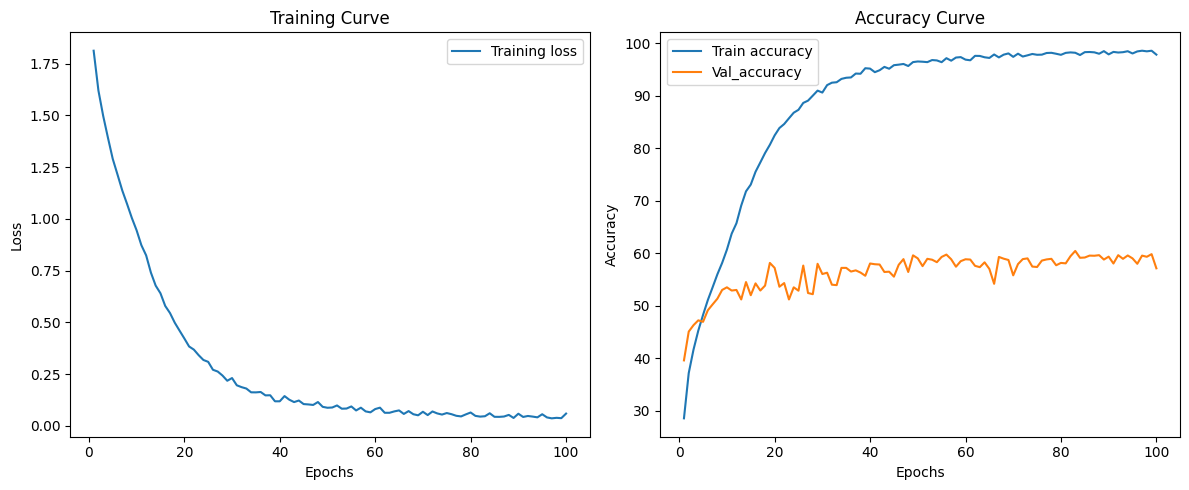

In [36]:
fig, axes = plt.subplots(ncols = 2, nrows = 1, figsize = (12, 5))

# Plot training curve
sns.lineplot(x = range(1, EPOCHS+1), y = train_loss_list, ax = axes[0], label = "Training loss")
axes[0].set_title("Training Curve")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")

# Plot accuracy curve
sns.lineplot(x = range(1, EPOCHS+1), y = train_acc_list, ax = axes[1], label = "Train accuracy")
sns.lineplot(x = range(1, EPOCHS+1), y = val_acc_list, ax = axes[1], label = "Val_accuracy")
axes[1].set_title("Accuracy Curve")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy")

plt.tight_layout()
plt.show()

### Evaluating

When the dataset is imbalanced, we need to use more metrics (`sklearn.metrics`) to evaluate the model:
+ `accuracy_score`: 
    $$
    Accuracy = \frac{(TP + TN)}{(TP + FP + TN + FN)}
    $$
+ `f1_score`: 2/(1/precision + 1/recall)
    $$
    F_1 = \frac{2}{\frac{1}{Precision} +\frac{1}{Recall}} = \frac{2}{\frac{1}{\frac{TP}{TP + FP}} +\frac{1}{\frac{TP}{TP + FN}}}
    $$
+ `confusion_matrix`: A table that provides detailed insights into how the model performs for each class, showing the number of true positives, true negatives, false positives, and false negatives. This helps identify specific weaknesses in class predictions.

In [37]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score

In [38]:
y_pred = []
y_true = []

model.load_state_dict(torch.load('./best_model.pth'))
model.eval()

with torch.inference_mode():
  for inputs, labels in test_dataloader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, predicted = outputs.max(1)
    y_pred.extend(predicted.cpu().numpy())
    y_true.extend(labels.cpu().numpy())

  print(classification_report(y_true, y_pred))

/tmp/ipykernel_63415/4252255968.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./best_model.pth'))


              precision    recall  f1-score   support

           0       0.52      0.55      0.53       491
           1       0.72      0.51      0.60        55
           2       0.52      0.40      0.45       528
           3       0.81      0.78      0.80       879
           4       0.47      0.40      0.43       594
           5       0.76      0.78      0.77       416
           6       0.51      0.69      0.58       626

    accuracy                           0.61      3589
   macro avg       0.62      0.59      0.60      3589
weighted avg       0.61      0.61      0.61      3589



In [39]:
print("F1 score macro:", f1_score(y_true, y_pred, average = 'macro'))

F1 score macro: 0.5954804257418855


In [40]:
print("Accuracy:", accuracy_score(y_true, y_pred))

Accuracy: 0.6101978266926721


## Conclusion
I have built a custom CNN model for predict people emotion from image in Fer 2013 dataset using `PyTorch`, successfully handled class imballace problem.

|Metric| Value|
|-----|-----|
|Accuracy| .6102|
|F1-Scrore(Macro)| .5955|
|Average| .602825|

Below are the bar charts for `F1-Score` and Correlation heatmap for predited and actual class.

In [74]:
f1_scores = f1_score(y_true, y_pred, average=None)

f1_data = pd.DataFrame({
    'Emotion': emotions,
    'F1-Score': f1_scores
})

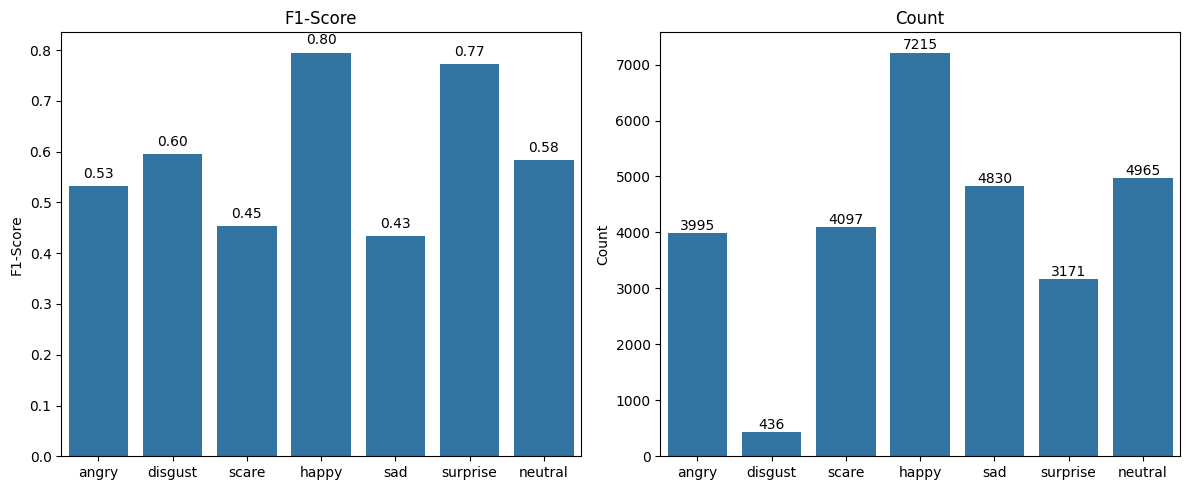

In [75]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 5))

#----F1 SCORE PLOT-------
sns.barplot(x='Emotion', y='F1-Score', data=f1_data, ax=axes[0])
axes[0].set_title("F1-Score")
axes[0].set_xlabel("")
axes[0].set_ylabel("F1-Score")

for i, bar in enumerate(axes[0].containers[0]):  # containers[0] contain bars
    value = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width() / 2, value + 0.01,  # label position
                 f"{value:.2f}", ha='center', va='bottom', fontsize=10)


#----COUNTPLOT-------
sns.barplot(y=emotion_count, x=emotions, ax=axes[1])
axes[1].set_title("Count")
axes[1].set_xlabel("")
axes[1].set_ylabel("Count")

for i, bar in enumerate(axes[1].containers[0]):
    value = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width() / 2, value + 1,
                 f"{int(value)}", ha='center', va='bottom', fontsize=10)


plt.tight_layout()
plt.show()

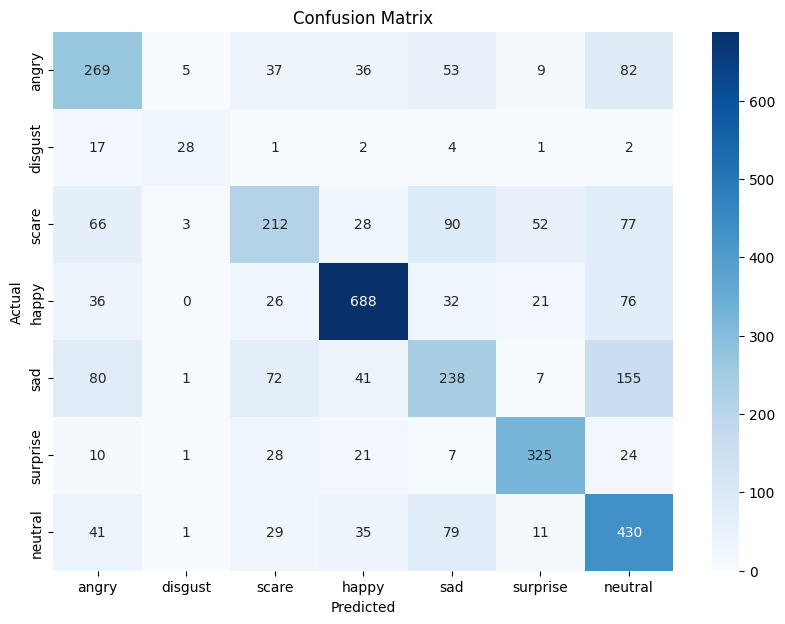

In [78]:
# confusion matrix heatmap
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotions, yticklabels=emotions)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.show()

Some prediction of the `X_test` by the model

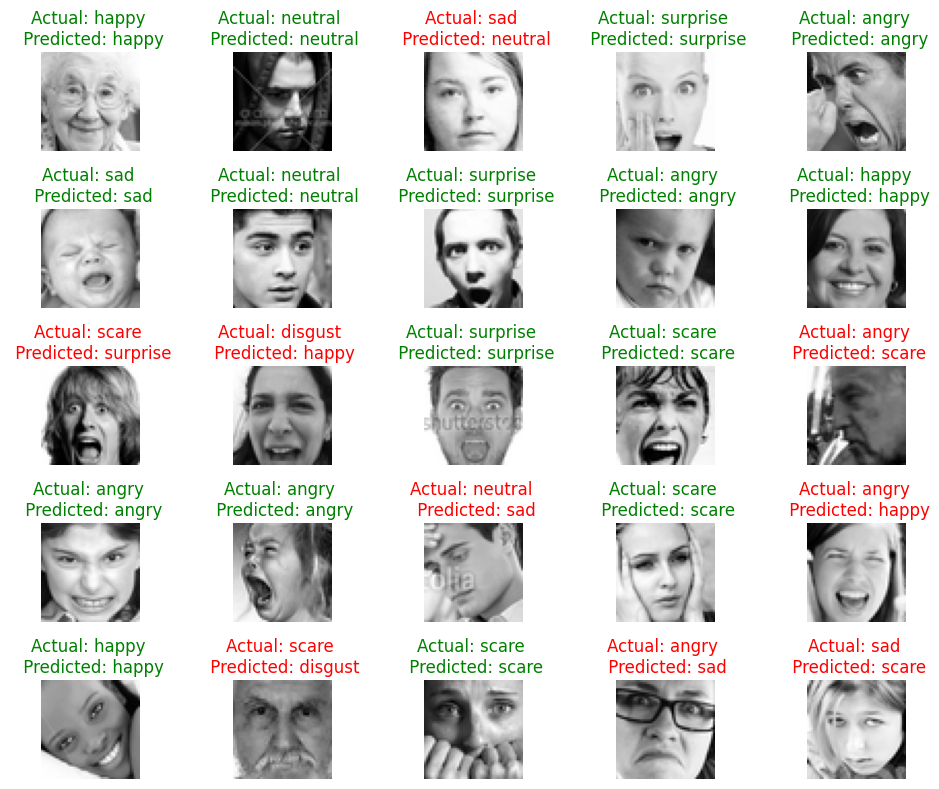

In [44]:
# show 25 random test image and model predictions of them
fig, axes = plt.subplots(ncols = 5, nrows = 5, figsize = (10, 8))
axes = axes.flatten()

for i in range(25):
  idx = np.random.randint(0, len(X_test))
  image = X_test[idx]
  label = y_test[idx]
  pred = y_pred[idx]

  if label == pred:
    title_color = 'green'
  else:
    title_color = 'red'
  
  axes[i].imshow(image.squeeze().cpu().numpy(), cmap = 'gray')
  axes[i].set_title(f"Actual: {emotions[label]} \n Predicted: {emotions[pred]}", color = title_color)
  axes[i].axis('off')

plt.tight_layout()
plt.show()